In [1]:
import string
import re
import matplotlib.pyplot as plt
import numpy as np

from numpy import array, asarray, zeros
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LSTM, CuDNNLSTM, Dense, Dropout, GlobalMaxPool1D, Bidirectional, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/ML/
%ls

/content/drive/My Drive/ML
model_plot4a.png                   project_amazon_review_3_mod.ipynb
models/                            project_amazon_review_4_mod.ipynb
output/                            project_amazon_review_5_mod.ipynb
project_amazon_review_1_mod.ipynb  weights/
project_amazon_review_2_mod.ipynb


### Put category list in list due to make it compatible with MultiLabelBinarizer

In [4]:
data = pd.read_csv('output/Amazon_reviews_mid_f1.csv', dtype=str,)
data.head()


,text,star_rating,sentiment_class,category_class
0,choose right list item beautiful intricate det...,5.0,Positive,product
1,sorry bill work downtown washington november j...,1.0,Negative,product
2,great taste start say book amazing world good ...,5.0,Positive,product
3,beyond religion endorsement support another su...,5.0,Positive,product
4,unique work generation edit would point ridicu...,5.0,Positive,product


In [5]:
data["classes"]=data["star_rating"]+", "+data['sentiment_class']+", "+data['category_class']
data.head()

,text,star_rating,sentiment_class,category_class,classes
0,choose right list item beautiful intricate det...,5.0,Positive,product,"5.0, Positive, product"
1,sorry bill work downtown washington november j...,1.0,Negative,product,"1.0, Negative, product"
2,great taste start say book amazing world good ...,5.0,Positive,product,"5.0, Positive, product"
3,beyond religion endorsement support another su...,5.0,Positive,product,"5.0, Positive, product"
4,unique work generation edit would point ridicu...,5.0,Positive,product,"5.0, Positive, product"


In [6]:
X = data["text"]
category_names = ['star_rating','sentiment_class', 'category_class']
Y = data[category_names]

In [7]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
Y["sentiment_class"]= label_encoder.fit_transform(Y["sentiment_class"])
Y["category_class"] = label_encoder.fit_transform(Y["category_class"])
Y["star_rating"] = Y["star_rating"].astype(float)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

### Use stratified splits because of class imbalance

In [8]:
test_split = 0.2

# Initial train and test split.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split, stratify = Y.values, shuffle = True, random_state=4)

In [9]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(44100,)
(11026,)
(44100, 3)
(11026, 3)


In [10]:
# vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary = "true")
# y_train = vectorizer.fit_transform(y_train).toarray()
# y_test = vectorizer.transform(y_test).toarray()
# Import label encoder


We first get percentile estimates of the sequence lengths. The purpose will be clear in a moment.

In [11]:
data["text"].apply(lambda x: len(x.split(" "))).describe()

count    55126.000000
mean        84.183235
std        160.130414
min         10.000000
25%         16.000000
50%         33.000000
75%         84.000000
max       3759.000000
Name: text, dtype: float64

Notice that 50% of the abstracts have a length of 8. So, any number close to that value is a good enough approximate for the maximum sequence length. However, I will chose max_len according to max value

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size: ", vocab_size)

maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

Vocab size:  92076


In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(44100, 100)
(11026, 100)
(44100, 3)
(11026, 3)


In [14]:
embeddings_dictionary = dict()

glove_file = open('output/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [15]:
# # MODEL 1

# model = keras.Sequential()
# # Configuring the parameters
# model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
# # model.add(Embedding(vocab_size, 100))
# model.add(LSTM(128, return_sequences=True))
# model.add(BatchNormalization())
# # Adding a dropout layer
# model.add(Dropout(0.4))
# model.add(LSTM(64))
# model.add(Dropout(0.3))
# # Adding a dense output layer with sigmoid activation
# model.add(Dense(y_train.shape[1], activation='sigmoid'))


# model.summary()

In [16]:
# Constants for model configuration
GPU = True
MAX_WORDS = 100
NO_OF_CLASSES = 3
VOCAB_SIZE = vocab_size
EPOCHS = 50
BATCH_SIZE = 1024
# Making the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, 128, input_length=MAX_WORDS))

model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Dropout(0.5))

model.add(Bidirectional(CuDNNLSTM(256, return_sequences = True)))

model.add(GlobalMaxPool1D())

model.add(Dense(256, activation="relu"))

model.add(Dense(128, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(NO_OF_CLASSES, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          11785728  
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 256)           98560     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 512)           393728    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 512)          0         
 1D)                                                    

In [17]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Added early stopping system to monnitor validation loss on each epoch and stops training when validation loss start to increase
monitor = EarlyStopping(monitor='val_loss', 
                        patience=5, 
                        mode='min',
                        restore_best_weights=True)

# Saving the model in every epochs for some experiments
checkpoint = ModelCheckpoint(filepath="weights/model.{epoch:02d}-{val_loss:.2f}.h5")

In [19]:
# Starting the training process
history =  model.fit(x_train, 
          y_train, 
          validation_data=(x_test, y_test), 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          callbacks=[monitor, checkpoint])

Epoch 1/50
44/44 [==============================] - 11s 140ms/step - loss: 435.8663 - accuracy: 0.8774 - val_loss: 1551.8376 - val_accuracy: 0.9093
Epoch 2/50
44/44 [==============================] - 5s 112ms/step - loss: 4433.5576 - accuracy: 0.8933 - val_loss: 8863.8232 - val_accuracy: 0.9093
Epoch 3/50
44/44 [==============================] - 5s 115ms/step - loss: 15679.7402 - accuracy: 0.8935 - val_loss: 24651.3848 - val_accuracy: 0.9093
Epoch 4/50
44/44 [==============================] - 5s 118ms/step - loss: 36035.6484 - accuracy: 0.8945 - val_loss: 49904.7695 - val_accuracy: 0.9093
Epoch 5/50
44/44 [==============================] - 5s 120ms/step - loss: 66263.0547 - accuracy: 0.8941 - val_loss: 84805.1016 - val_accuracy: 0.9093
Epoch 6/50
44/44 [==============================] - 5s 116ms/step - loss: 105525.4375 - accuracy: 0.8934 - val_loss: 129240.0156 - val_accuracy: 0.9093


In [20]:
# Saving the model
model.save('weights/model_best_CuDNNLSTM.h5')

In [21]:
model2 = keras.models.load_model('weights/model_best_CuDNNLSTM.h5')

In [22]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
review = "product great"

review_vec = tokenizer.texts_to_sequences([review])
    
review_vec_pad = pad_sequences(review_vec, MAX_WORDS, padding='post')
    
# Predicting the class
# predict_class = model2.predict_classes(review_vec_pad)
predict_x=model.predict(review_vec_pad) 
classes_x=np.argmax(predict_x,axis=1)
    
# Predicting probs
predict_prob = model2.predict(review_vec_pad)
    
# Printing the class and prob values
print(classes_x[0] + 1, predict_prob)

1/1 [==============================] - 0s 280ms/step
1 [[1. 0. 0.]]


In [24]:
# METRICS = [
# #     keras.metrics.BinaryAccuracy(name='accuracy'),
#     "categorical_accuracy",
#     keras.metrics.Precision(name='precision'),
#     keras.metrics.Recall(name='recall'),
# ]

In [25]:
# # Define optimizer
# optimizer = keras.optimizers.Adam(learning_rate=5e-5)

# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = METRICS)

In [26]:
# history = model.fit(x_train,y_train,
#                     epochs = 5,
#                     verbose = 1,
#                     validation_split=0.3,
#                     batch_size=128)

In [27]:
# model.save("models/model_last.h5")

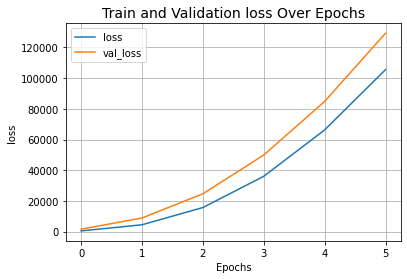

In [30]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")


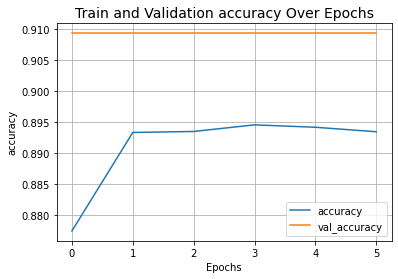

In [32]:
plot_result("accuracy")

## Evaluate the model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

predictions=model.predict([x_test])
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]

for val in thresholds:
    print("For threshold: ", val)
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

In [ ]:
Y_pred = model.predict(x_test)


In [ ]:
def predict_sample(text):
    encoded_text = tokenizer.texts_to_sequences(text)
    
    padded_docs = pad_sequences(encoded_text, maxlen=maxlen, padding='post')
    
    pred = model.predict(padded_docs).tolist()
    for i in range(len(pred[0])):
        if(pred[0][i] < 0.4):
            pred[0][i] = 0
        else:
            pred[0][i] = 1
    
    print("Predicted tags -->", vectorizer.inverse_transform(pred[0])[0])

In [ ]:
import pickle

# saving
with open('models/tokenizer_last.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import dill

dill.dumps(vectorizer, open('models/vectorizer.pkl', 'wb'))

In [ ]:
from tensorflow import keras
model = keras.models.load_model('models/model_last.h5')

In [ ]:
import pickle

# loading
with open('models/tokenizer_last.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
encoded_text = tokenizer.texts_to_sequences(data["text"][5])
    
padded_docs = pad_sequences(encoded_text, maxlen=100, padding='post')

pred = model.predict(padded_docs).tolist()
for i in range(len(pred[0])):
    if(pred[0][i] < 0.4):
        pred[0][i] = 0
    else:
        pred[0][i] = 1

vectorizer.inverse_transform(pred)[0]